# Excercises 

## 0. Setup your own repo
- Setting up a repo is often repetitive. That's why you can use what are called 'cookiecutters', providing you with a template structure with some basic folders and files already set up for you. You don't have to use one, and can do it by hand, but have a look and maybe you think it is helpful.
    - You could use the `cookiecutter` command that is preinstalled on your VM to create a repo, see https://github.com/raoulg/datascience-cookiecutter for details. I made this one myself, because I ended up editing the cookiecutter I was using.
    - Another project is this one https://github.com/drivendata/cookiecutter-data-science , also intended for data science projects
    - more general cookiecutters are shipped with tools like [pdm](https://pdm-project.org/latest/) and [rye](https://rye-up.com/); starting a project with `pdm init` or `rye init` (see docs for details) will provide you with some minimal structure, and there is the option to provide your own template with pdm (see [pdm template](https://pdm-project.org/latest/usage/template/))
- push your own repo to github. Use `IECS-Advanced-AI-{yourname}` as a format, eg `IECS-Advanced-AI-SarmientoC`.
- Invite (clein2312; https://github.com/Clein2312) as a collaborator to your repo.
- make the excercises 1-5 below in your repo, and push them to github.

Tips:
- Commit often (every 30 minutes or so) 
- really, commit often. commiting and pushing your work is the best way to make sure your work is saved properly.
- Commit groups of files that are related to each other. If you have more files, commit them separately.
- Write commit messages that are descriptive and informative. "lesson 1", "changes" or "commit" are bad commit messages; "added excercise 2" is better, "[exercise 2] added __len__ to Dataset class" is even better.
- Use `pdm` or `rye` to add dependencies. `mads_datasets` and `mltrainer` should cover a lot of what you need; don't blindly copy-paste all dependencies but keep your `pyproject.toml` as clean as possible.

At some point, you will get a grade for the excercises that is 0 (not good enough), 1 (good enough) or 2 (excellent).
I will look for both form and correctness to determine your grade.
The result be incorporated into your final grade for this course.

## 1. 3D Tensor dataset
- Create a random 3D tensor dataset with `torch`

<font color='green'>

**Solution:** In the following code we created a `random` tensor of shape `(32, 10)`, which can be think of as random data with 32 observations with 10 features.
</font>


In [63]:
import torch
X = torch.rand(32, 10)
X.shape

torch.Size([32, 10])

- Build your own `DataSet` class, such that you can get a 3D tensor and a label (which can be a random 0 or 1)
See notebook 03_dataloader for details on how to create a custom dataset. See 01_tensors and the torch documentation how to create random tensors.

<font color='green'>

**Solution:** In the following code we defined a custom dataloader with the name of `DataSet`. This dataloader should have the minmum 3 functions; `__init__` (to initialize the dataset), `__len__` (returns the total lenght of the dataset), and `__getitem__` (returns the data and target values when iterated over the initialized dataset). The usability will be discussed in the next section of datastreamers.
</font>

In [64]:
from typing import Iterator, Tuple, List
class DataSet:
    def __init__(self, data, targets) -> None:
        self.data = data
        self.targets = targets

    def __len__(self) -> int:
        return len(self.data)

    # It will iterate the data and targets provided in the initilization phase
    def __getitem__(self, idx: int) -> Tuple:
        return self.data[idx], self.targets[idx]

## 2. Datastreamers
Study the `BaseDatastreamer` in `03_dataloader` and use it with your own dataset, such that you get a datastreamer that will keep on giving you new batches of data when you call `next()` or loop over it.

<font color='green'>

**Solution:** In order to get the `BaseDatastreamer` working to call the next batch from the function `next()`, we first need to create the random dataset. As the `BaseDatastreamer` requires the dataset to be in a `tuple`, we will append the `X` and `y` together in a tuple. 

Lets suppose we a image dataset, and each image shape is `(3, 128, 128)`. In total we have eaxactly `500` images. The iteration will be processed by our preiously built `DataSet` class.
</font>

In [65]:
X = torch.rand(500, 3, 256, 256)    # 500 image dataset
y = torch.rand(500,)                # 500 target values

# Our custom data holds all the 500 images and targets
customData = DataSet(X, y)


In [66]:
X, y = customData[1]
X.shape, y, len(customData)

(torch.Size([3, 256, 256]), tensor(0.8866), 500)

In [67]:
import numpy as np

# this barch process is required by BaseDatastreamer to iterate in batches
# this will stack the batches of image and targets
def batch_processor(batch):
    X, Y = zip(*batch)
    return np.stack(X), np.array(Y)

In [68]:
from mads_datasets.base import BaseDatastreamer

# this will create a streamer iterate over the dataset
streamer = BaseDatastreamer(
    dataset=customData,
    batchsize=32,
    preprocessor=batch_processor
)

<font color='green'>

**The `next()` function will give the next new batch from the dataset to train.**
</font>

In [69]:
gen = streamer.stream()
X, y = next(gen)
X.shape, y.shape


((32, 3, 256, 256), (32,))

# 3. Tune the network
For this exercise we won't build upon the previous exercises, but instead will use the Fashion dataset.
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 

<font color='green'>

#### Note: 
**This code requires specific version of the libraries `mltrainer==0.1.129` and `gin-config==0.5.0`**

</font>

In [70]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
import gin

In [71]:
# gin.external_configurable(imagemodels.NeuralNetwork, module="imagemodels")
gin.parse_config_file("model.gin")

ParsedConfigFileIncludesAndImports(filename='model.gin', imports=['gin.torch.external_configurables'], includes=[])

<font color='green'>

**Note:** The above warning is due to library mismatch. This is an depreceation warning and it will not impact in the results of our experiments.
</font>

We will be using `gin-config` to easily keep track of our experiments, and to easily save the different things we did during our experiments.

The `model.gin` file is a simple file that will try to load parameters for funcitons that are already imported. 

So, if you wouldnt have imported train_model, the ginfile would not be able to parse settings for train_model.trainloop and will give an error.

We can print all the settings that are operational with `gin.operative_config_str()` once we have loaded the functions to memory.

In [72]:

preprocessor = BasePreprocessor()
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-02-17 14:18:02.206 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/fashionmnist
2025-02-17 14:18:02.207 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [73]:
print(gin.config_str())

import gin.torch.external_configurables

# Parameters for NeuralNetwork:
# ==============================================================================
NeuralNetwork.num_classes = 10
NeuralNetwork.units1 = 512



A big advantage is that we can save this config as a file; that way it is easy to track what you changed during your experiments.

In [74]:
accuracy = metrics.Accuracy()

In [75]:
import torch
gin.parse_config_file("model.gin")

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=5,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN],
)

for unit1 in units:
    for unit2 in units:
        gin.bind_parameter("NeuralNetwork.units1", unit1)
        gin.bind_parameter("NeuralNetwork.units2", unit2)

        model = imagemodels.NeuralNetwork()
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


2025-02-17 14:18:02.286 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellogs/20250217-141802
2025-02-17 14:18:02.740 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 937/937 [00:03<00:00, 283.34it/s]
2025-02-17 14:18:06.329 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5121 test 0.4127 metric ['0.8524']
100%|██████████| 937/937 [00:04<00:00, 234.18it/s]
2025-02-17 14:18:10.621 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3668 test 0.3779 metric ['0.8679']
100%|██████████| 937/937 [00:04<00:00, 230.82it/s]
2025-02-17 14:18:14.990 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3282 test 0.3487 metric ['0.8745']
100%|██████████| 937/937 [00:03<00:00, 237.40it/s]
2025-02-17 14:18:19.241 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3048 test 0.3509 metric ['0.8773']
2025-02-17 14:18:19.242 | INFO     | mltrainer.trainer:__

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=models` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`


Experiment with things like:

- changing the amount of units1 and units2 to values between 16 and 1024. Use factors of 2: 16, 32, 64, etc.

<font color='green'>

**Answer:** units1 and unist2 as factors of 2 (16 to 1024) are [16, 32, 64, 128, 256, 512, 1024]. By keeping the computational complexity of these, we limited the search space to [64, 128, 256]. However, it can be changed later to have all the values.
</font>

- changing the batchsize to values between 4 and 128. Again, use factors of two.

<font color='green'>

**Answer:** For the batch size value we keep all the values between 4 and 128 (by factor of 2), i.e. [4, 8, 16, 32, 64, 128].
</font>

- all your experiments are saved in the `modelslogs` directory, with a timestamp. Inside you find a saved_config.gin file, that 
contains all the settings for that experiment. The `events` file is what tensorboard will show.

<font color='green'>

**Answer:** All experiemnts are saved within the `modelslogs` directory with the timestampe for example `experiment_20250215_123844`, inside you will find 2 files, `saved_config.gin` (contains experiemnt configuration) and `events` file (contains tensorboard logs during tarining for loss and accuracy values.)
</font>

- plot the result in a heatmap: units vs batchsize.

<font color='green'>

**Answer:** At the very end. The heatmap is plotted and explanation is provided for it.
</font>

- changing the learningrate to values between 1e-2 and 1e-5 

<font color='green'>

**Answer:** For consistency among our experiments, we kept the learning rate value to 1e-5. Otherwise, we might see influence of learning rate on accuracy, however, our main goal is to see corelation between units vs. batchsize in terms of model accuracy.  
</font>

- changing the optimizer from SGD to one of the other available algoritms at [torch](https://pytorch.org/docs/stable/optim.html) (scroll down for the algorithms)

<font color='green'>

**Answer:** For the following experiments, we use the `Adam` optimizer. 
</font>

A note on train_steps: this is a setting that determines how often you get an update. 
Because our complete dataset is 938 (60000 / 64) batches long, you will need 938 trainstep to cover the complete 60.000 images.

This can actually be a bit confusion, because every value below 938 changes the meaning of `epoch` slightly, because one epoch is no longer
the full dataset, but simply `trainstep` batches. Setting trainsteps to 100 means you need to wait twice as long before you get feedback on the performance,
as compared to trainsteps=50. You will also see that settings trainsteps to 100 improves the learning, but that is simply because the model has seen twice as 
much examples as compared to trainsteps=50.

This implies that it is not usefull to compare trainsteps=50 and trainsteps=100, because setting it to 100 will always be better.
Just pick an amount, and adjust your number of epochs accordingly.


<font color='green'>

### Experiments

##### Experiemnt with the other model parameters to inspect the change in final output results.
</font>

<font color='green'>

You can use `list` to write each parameter individually. This way we can see what we are working on.

</font>

In [76]:
from torch import optim
# units1 and units2 as factors of 2 (16 to 1024) are [16, 32, 64, 128, 256, 512, 1024]
# choosing only few to have the intiuation of what is the effect of these on batch_sizes
# however you can change have larger space to see the results
units_values = [64, 128, 256]

# batch sizes as factors of 2 (4 to 128)
batch_sizes = [4, 8, 16, 32, 64, 128]

optimizer = optim.Adam  # Different optimizer other than SGD

In [77]:
units_values

[64, 128, 256]

In [78]:
preprocessor = BasePreprocessor()
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
# Other functions will be initialized in the Experiment section 


<font color='green'>

Following is the helper function which will help to load the tensorbaord values in a list. We will use it later to store the accuracy for that training iteration. You can load the tensorboard as defined previously to confirm under what name the `accuracy` of the model is being logged. By inspecting the tensorboard, it has seen that we get the accuracy under the tag of `metric\Accuracy` 

**Note: (if you want to use this helper function somewhere else, please change this tag to match your tensorboad logs.)**

</font>

In [79]:
# This is a helper function to load tensorboard values
# you can also write it in another .py script and load it in here to keep your code clean.
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard_data(logdir):
    """
    Load TensorBoard data from the specified log directory.
    Returns a dictionary of metrics and their values over epochs.
    """
    # Initialize EventAccumulator
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    # Extract scalar data
    metrics = []
    for tag in event_acc.Tags()["scalars"]:
        if tag == 'metric/Accuracy':
            events = event_acc.Scalars(tag)
            metrics = [event.value for event in events]

    return metrics

<font color='green'>

Each model needs to be trained and evaluated to determine which combination of hyperparameters performs best. We use accuracy as the metric to compare different configurations. So, we will store the final accuracy of each experiment in `results` list.

</font>

In [80]:
# For heatmap (units vs. batchsize)
import numpy as np
results = np.zeros((len(units_values), (len(batch_sizes))))

<font color='green'>

Lets do the experiment on all the combination of the `unit1` and `unit2`. The values of these variabels is defined previously. The results for each combination will be stored to built the heatmap.

</font>

In [81]:
import gin
import torch
from datetime import datetime


gin.parse_config_file("model.gin")

loss_fn = torch.nn.CrossEntropyLoss()

# Experiment loop
for unit1 in units_values:
    for unit2 in units_values:
        for batch_size in batch_sizes:
            # Create datastreamers with current batchsize
            streamers = fashionfactory.create_datastreamer(batchsize=batch_size, preprocessor=preprocessor)
            train = streamers["train"]
            valid = streamers["valid"]
            trainstreamer = train.stream()
            validstreamer = valid.stream()

            # Bind hyperparameters to the gin configuration
            gin.bind_parameter("NeuralNetwork.units1", unit1)
            gin.bind_parameter("NeuralNetwork.units2", unit2)

            # Initialize model
            model = imagemodels.NeuralNetwork()

            """
            To store experiments with timesamps we will dataetime library to get the current time to store 
            the model at that timestamps.
            """
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            logdir = f"modellogs/experiment_{timestamp}"

            # Define trainer settings
            settings = TrainerSettings(
                epochs=5,
                metrics=[accuracy],
                logdir=logdir,
                train_steps=len(train),
                valid_steps=len(valid),
                reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN],
            )

            # Similar to previous example initialize trainer
            # this will helps us to train and log the values in the logdir
            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer,
                validdataloader=validstreamer,
                scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            )

            # Train the model
            trainer.loop()

            # Save results for plotting heat-map
            import os
            # This will get the path file where we store the tensorboard values.
            dirs = [os.path.join(logdir, d) for d in os.listdir(logdir) if os.path.isdir(os.path.join(logdir, d))]
            
            # `load_tensorboard_data` function is defined earlier, which will load the values from the stored tensorboard
            metrics = load_tensorboard_data(dirs[0])
            final_accuracy = metrics[-1]
            results[units.index(unit1), batch_sizes.index(batch_size)] = final_accuracy

2025-02-17 14:20:28.643 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/fashionmnist
2025-02-17 14:20:28.644 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 14:20:28.669 | INFO     | mltrainer.settings:check_path:61 - Created logdir /home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_1/notebooks/1_pytorch_intro/modellogs/experiment_20250217_142028
2025-02-17 14:20:28.670 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellogs/experiment_20250217_142028/20250217-142028
2025-02-17 14:20:28.671 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 15000/15000 [00:15<00:00, 937.77it/s]
2025-02-17 14:20:45.323 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4943 test 0.4550 metric ['0.8336']
10

<font color='green'>

The above experiments are run for 5 epochs for each combination of the `unit1`, `unit2`, and `batch_size`. As you can see the results in the above section, the final accuracy range from 85% to 88% depending on the values provided for each variable. We will next plot the heatmap for these values to visually see the relation between them.
</font>

<font color='green'>

After running multiple experiments, we need a clear way to analyze performance trends. A heatmap helps compare accuracy across different units and batch sizes. We are plotting a heatmap using `seaborn` library.
</font>


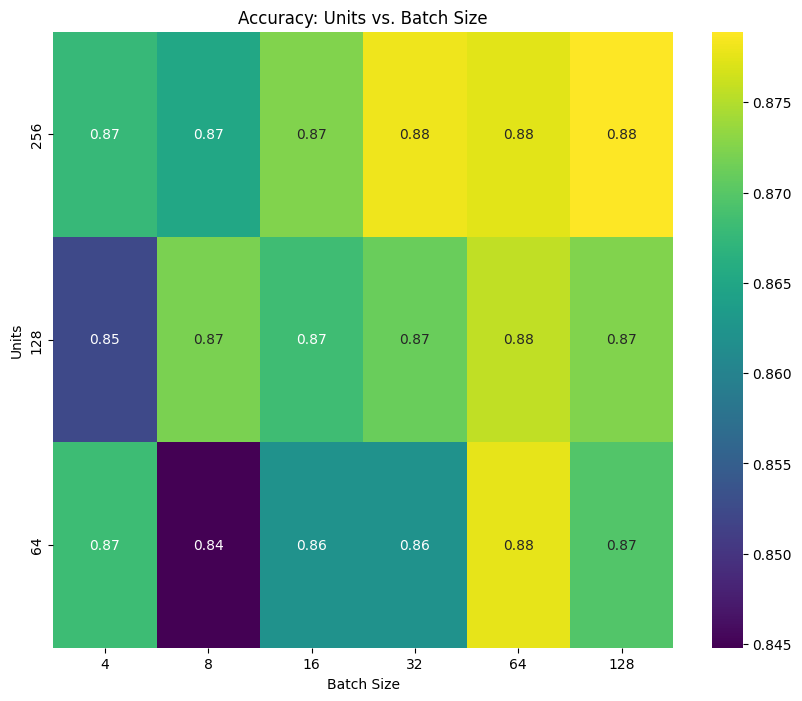

In [82]:
# Plot heatmap for units vs. batchsize
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=batch_sizes, yticklabels=units, cmap="viridis")
plt.xlabel("Batch Size")
plt.ylabel("Units")
plt.title("Accuracy: Units vs. Batch Size")
plt.savefig("units_vs_batchsize_heatmap.png")
plt.show()

In [83]:
print(results)


[[0.86769998 0.86510003 0.8725     0.87800479 0.87740386 0.87890625]
 [0.85229999 0.87199998 0.86830002 0.87109375 0.87570113 0.87239581]
 [0.8682     0.8448     0.86220002 0.86207932 0.87770432 0.86969149]]


<font color='green'>
In this heatmap, we are comparing accuracy across different configurations of units (neurons per layer) and batch sizes to see how they impact model performance. The x-axis represents batch size (ranging from 4 to 128), while the y-axis represents the number of units (64, 128, and 256). The brighter colors indicate higher accuracy, and we can see that larger batch sizes (64 and 128) consistently lead to better accuracy, with the highest at 256 units and batch sizes of 64 or 128 (0.88 accuracy). While increasing the number of units improves performance slightly, its impact is not as significant as batch size, which suggests that for better model accuracy, optimizing batch size is more effective than simply adding more neurons.
</font>
